In [5]:
import sqlite3
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

import sys
import os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
from include_columns import include_columns_corr_ml

dataset = "games_2018-present"
db = sqlite3.connect(f"/Users/aidenflynn/ML_Python/python-nfl/Data/v2.sqlite")
df = pd.read_sql_query(f"select * from \"{dataset}\"", db, index_col="index")

# fill scrm RELATED column Null with 0.0
df['AWAY_PASS_YDSSCRM_MAX'] = df['AWAY_PASS_YDSSCRM_MAX'].fillna(0.0)
df['AWAY_PASS_YDSSCRM_MEAN'] = df['AWAY_PASS_YDSSCRM_MEAN'].fillna(0.0)
df['AWAY_PASS_YDSSCRM_MIN'] = df['AWAY_PASS_YDSSCRM_MIN'].fillna(0.0)
df['AWAY_PASS_YDSSCRM_STD'] = df['AWAY_PASS_YDSSCRM_STD'].fillna(0.0)
df['HOME_PASS_YDSSCRM_MAX'] = df['HOME_PASS_YDSSCRM_MAX'].fillna(0.0)
df['HOME_PASS_YDSSCRM_MEAN'] = df['HOME_PASS_YDSSCRM_MEAN'].fillna(0.0)
df['HOME_PASS_YDSSCRM_MIN'] = df['HOME_PASS_YDSSCRM_MIN'].fillna(0.0)
df['HOME_PASS_YDSSCRM_STD'] = df['HOME_PASS_YDSSCRM_STD'].fillna(0.0)
# All other null values can be safely filled with -1: unavailable
df.fillna(-1, inplace=True) 
df.isnull().any(axis=1).sum()

df['HOME_PASS_PLAYOFF_WINPCT'] = np.where(
    (df['HOME_PASS_PLAYOFF_W'] + df['HOME_PASS_PLAYOFF_L']) > 0,
    df['HOME_PASS_PLAYOFF_W'] / (df['HOME_PASS_PLAYOFF_W'] + df['HOME_PASS_PLAYOFF_L']),
    -1
)
df['HOME_PASS_PLAYOFF_GAMES'] = df['HOME_PASS_PLAYOFF_W'] + df['HOME_PASS_PLAYOFF_L']

df['HOME_PASS_BIG_GAME_WINPCT'] = np.where(
    (df['HOME_PASS_BIG_GAME_W'] + df['HOME_PASS_BIG_GAME_L']) > 0,
    df['HOME_PASS_BIG_GAME_W'] / (df['HOME_PASS_BIG_GAME_W'] + df['HOME_PASS_BIG_GAME_L']),
    -1
)
df['HOME_PASS_BIG_GAMES'] = df['HOME_PASS_BIG_GAME_W'] + df['HOME_PASS_BIG_GAME_L']

# target home team win; drop dud and standard columns
TARGET = df['Home-Team-Win']
df = df.drop(
    [
        'ROOF', 'SURFACE', 'TEMP', 'WIND_SPEED', 'SPREAD_COVER', 'SPREAD', 'OU_COVER', 'OU', 'SCORE', 'Home-Team-Win', 'HOME_SCORE', 
        'AWAY_SCORE', 'HOME_TEAM_NAME', 'AWAY_TEAM_NAME', 'SEASON', 'AWAY_PASS_PLAYOFF_L', 'HOME_PASS_PLAYOFF_W', 'HOME_PASS_PLAYOFF_L',
        'AWAY_PASS_PLAYOFF_W','AWAY_PASS_BIG_GAME_W', 'AWAY_PASS_BIG_GAME_L', 'HOME_PASS_BIG_GAME_W', 'HOME_PASS_BIG_GAME_L'
    ], 
    axis=1
)

# split data for training
x_train, x_test, y_train, y_test = train_test_split(df, TARGET, test_size=.3)

In [6]:
# Example: Remove constant features
selector = VarianceThreshold(threshold=0.0)
X_reduced = selector.fit_transform(x_train)

X_reduced = pd.DataFrame(X_reduced, columns=x_train.columns[selector.get_support()])
X_reduced = X_reduced.loc[:, ~X_reduced.T.duplicated()]

corr_matrix = X_reduced.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_reduced = X_reduced.drop(columns=to_drop)

model = RandomForestClassifier()
model.fit(X_reduced, y_train)

# Get feature importance
importances = model.feature_importances_
importance_df = pd.DataFrame({'feature': X_reduced.columns, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Select top 250 features
top_features = importance_df['feature'].head(250).tolist()
X_selected = X_reduced[top_features] # new X_train
X_test_selected = x_test[top_features] # new X_test 

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# # Random Forest with GridSearchCV

# # 'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}

# param_grid_rf = {
#     'n_estimators': list(range(60,71)),
#     'max_depth': [4,5,6],
#     'min_samples_split': [2,3],
#     'min_samples_leaf': [1,2,3],
#     'max_leaf_nodes': [10,11,12],
#     'ccp_alpha': [0.01,0.005,0.001,0.0005]
# }

# grid_rf = GridSearchCV(
#     RandomForestClassifier(random_state=42), 
#     param_grid_rf, 
#     cv=5, 
#     scoring='accuracy',
#     n_jobs=-1
# )

# grid_rf.fit(X_selected, y_train)

# # Best Random Forest model
# best_rf = grid_rf.best_estimator_
# y_pred_rf = best_rf.predict(X_test_selected)

# # Print results
# print("\nRandom Forest Results:")
# print(f"Best Parameters: {grid_rf.best_params_}")
# print(f"Cross-Validation Accuracy: {grid_rf.best_score_:.4f}")
# print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
# print(classification_report(y_test, y_pred_rf,digits=4))

# # Fix confusion matrix plotting
# fig, ax = plt.subplots(figsize=(5, 5))
# ConfusionMatrixDisplay.from_estimator(best_rf, X_test_selected, y_test, cmap='Purples', ax=ax)
# ax.set_title("Random Forest")
# plt.show()

In [8]:
random_state = 42
def run_random_forest_classifier(X_train, y_train, 
                                n_estimators = 100,       
                                max_depth = None,         
                                min_samples_split = 2,    
                                min_samples_leaf = 1,     
                                max_samples = None,       
                                max_leaf_nodes=None,
                                max_features = 1.0,       
                                bootstrap = True,         
                                random_state = random_state,
                                cv=5,
                                ccp_alpha=0.0,
                                n_jobs=-1
                               ):
    
    rf_model = RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        max_samples = max_samples,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        max_features = max_features,
        max_leaf_nodes=max_leaf_nodes,
        bootstrap = bootstrap,
        n_jobs = n_jobs,              # use all possible cores
        random_state = random_state,
        ccp_alpha=ccp_alpha,
    )
    
    scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=n_jobs)

    mean_acc = np.mean(scores)  # Convert to positive MSE
    return mean_acc

In [9]:
run_random_forest_classifier(X_selected, y_train, 
                                n_estimators = 100,       
                                max_depth = None,         
                                min_samples_split = 2,    
                                min_samples_leaf = 1,     
                                max_samples = None,       
                                max_leaf_nodes=None,
                                max_features = 1.0,             
                                ccp_alpha=0.0,
                               )

0.613666702843499

100%|██████████| 20/20 [07:48<00:00, 23.41s/it]


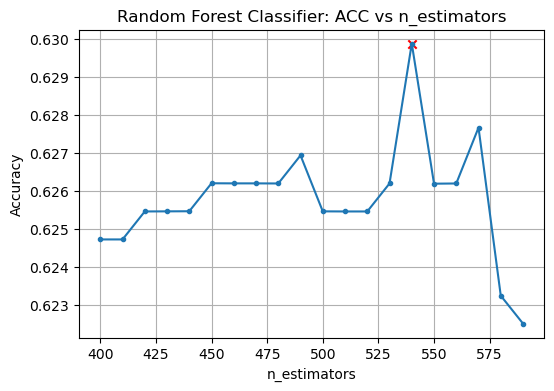

Max Accuracy 0.6299 found at x = 540


NameError: name 'format_time' is not defined

In [15]:
# Plot a n_estimators vs ACC using a simple for loop
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# record beginning time
start = time.time()

param = 'n_estimators'  

# parameter_list = range(400,1000,50) 
parameter_list = range(400,600,10)      

accs = []

for n in tqdm(parameter_list):
    accs.append( run_random_forest_classifier(X_selected, y_train, 
                                n_estimators = n,       
                                max_depth = None,         
                                min_samples_split = 2,    
                                min_samples_leaf = 1,     
                                max_samples = None,       
                                max_leaf_nodes=None,
                                max_features = 1.0,             
                                ccp_alpha=0.0,
                               ) ) 


                            
# Find the max value
max_acc = max(accs)

# Find the index of the minimum value
max_index = accs.index(max_acc)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Classifier: ACC vs "+param)
plt.plot(parameter_list, accs, marker='.')
plt.scatter([parameter_list[max_index]],[max_acc],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("Accuracy")
plt.grid()
plt.show()

if isinstance(parameter_list[max_index], int):
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]}")
else:
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

In [16]:
def format_time(seconds):
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

100%|██████████| 17/17 [06:01<00:00, 21.26s/it]


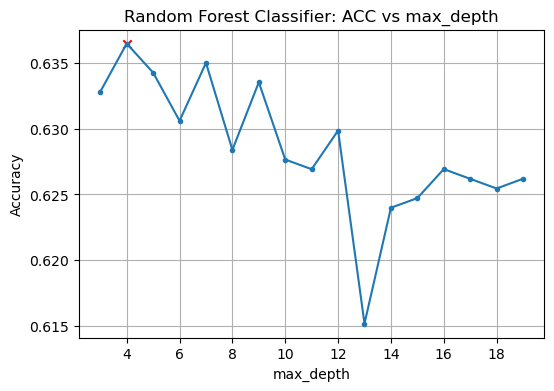

Max Accuracy 0.6365 found at x = 4
Execution Time: 6m 1.50s


In [18]:
# Plot a n_estimators vs ACC using a simple for loop
# import matplotlib.pyplot as plt
# import time
# from tqdm import tqdm

# record beginning time
start = time.time()

param = 'max_depth'  

parameter_list = range(3,20)

accs = []

for n in tqdm(parameter_list):
    accs.append( run_random_forest_classifier(X_selected, y_train, 
                                n_estimators = 540,       
                                max_depth = n,         
                                min_samples_split = 2,    
                                min_samples_leaf = 1,     
                                max_samples = None,       
                                max_leaf_nodes=None,
                                max_features = 1.0,             
                                ccp_alpha=0.0,
                               ) ) 


                            
# Find the max value
max_acc = max(accs)

# Find the index of the minimum value
max_index = accs.index(max_acc)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Classifier: ACC vs "+param)
plt.plot(parameter_list, accs, marker='.')
plt.scatter([parameter_list[max_index]],[max_acc],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("Accuracy")
plt.grid()
plt.show()

if isinstance(parameter_list[max_index], int):
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]}")
else:
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

100%|██████████| 13/13 [02:33<00:00, 11.81s/it]


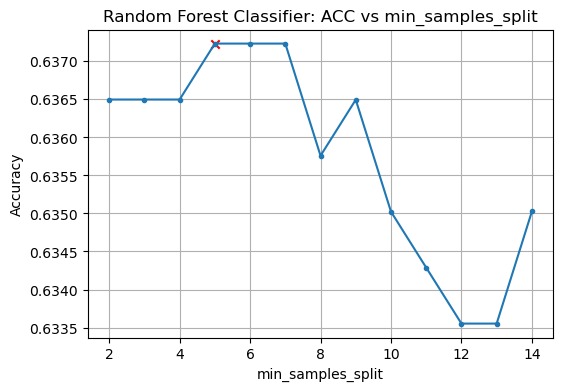

Max Accuracy 0.6372 found at x = 5
Execution Time: 2m 33.66s


In [21]:
# Plot a n_estimators vs ACC using a simple for loop
# import matplotlib.pyplot as plt
# import time
# from tqdm import tqdm

# record beginning time
start = time.time()

param = 'min_samples_split'  

parameter_list = range(2,15)

accs = []

for n in tqdm(parameter_list):
    accs.append( run_random_forest_classifier(X_selected, y_train, 
                                n_estimators = 540,       
                                max_depth = 4,         
                                min_samples_split = n,    
                                min_samples_leaf = 1,     
                                max_samples = None,       
                                max_leaf_nodes=None,
                                max_features = 1.0,             
                                ccp_alpha=0.0,
                               ) ) 


                            
# Find the max value
max_acc = max(accs)

# Find the index of the minimum value
max_index = accs.index(max_acc)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Classifier: ACC vs "+param)
plt.plot(parameter_list, accs, marker='.')
plt.scatter([parameter_list[max_index]],[max_acc],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("Accuracy")
plt.grid()
plt.show()

if isinstance(parameter_list[max_index], int):
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]}")
else:
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

100%|██████████| 14/14 [02:40<00:00, 11.44s/it]


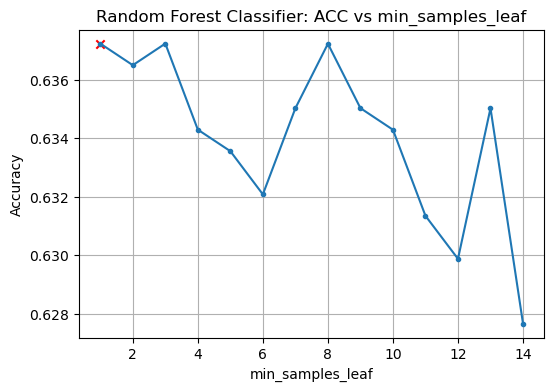

Max Accuracy 0.6372 found at x = 1
Execution Time: 2m 40.18s


In [22]:
# record beginning time
start = time.time()

param = 'min_samples_leaf'  

parameter_list = range(1,15)

accs = []

for n in tqdm(parameter_list):
    accs.append( run_random_forest_classifier(X_selected, y_train, 
                                n_estimators = 540,       
                                max_depth = 4,         
                                min_samples_split = 5,    
                                min_samples_leaf = n,     
                                max_samples = None,       
                                max_leaf_nodes=None,
                                max_features = 1.0,             
                                ccp_alpha=0.0,
                               ) ) 


                            
# Find the max value
max_acc = max(accs)

# Find the index of the minimum value
max_index = accs.index(max_acc)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Classifier: ACC vs "+param)
plt.plot(parameter_list, accs, marker='.')
plt.scatter([parameter_list[max_index]],[max_acc],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("Accuracy")
plt.grid()
plt.show()

if isinstance(parameter_list[max_index], int):
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]}")
else:
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

In [ ]:
# record beginning time
start = time.time()

param = 'max_samples'  

parameter_list = np.linspace(0.5,1.0,11)  

accs = []

for n in tqdm(parameter_list):
    accs.append( run_random_forest_classifier(X_selected, y_train, 
                                n_estimators = 540,       
                                max_depth = 4,         
                                min_samples_split = 5,    
                                min_samples_leaf = 1,     
                                max_samples = n,       
                                max_leaf_nodes=None,
                                max_features = 1.0,             
                                ccp_alpha=0.0,
                               ) ) 


                            
# Find the max value
max_acc = max(accs)

# Find the index of the minimum value
max_index = accs.index(max_acc)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Classifier: ACC vs "+param)
plt.plot(parameter_list, accs, marker='.')
plt.scatter([parameter_list[max_index]],[max_acc],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("Accuracy")
plt.grid()
plt.show()

if isinstance(parameter_list[max_index], int):
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]}")
else:
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

 14%|█▍        | 3/21 [00:34<03:26, 11.46s/it]


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_samples' parameter of RandomForestClassifier must be None, a float in the range (0.0, 1.0] or an int in the range [1, inf). Got 1.05 instead.


100%|██████████| 31/31 [05:40<00:00, 10.98s/it]


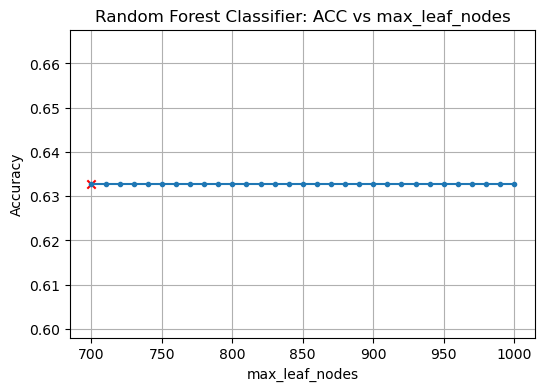

Max Accuracy 0.6328 found at x = 700
Execution Time: 5m 40.45s


In [26]:
# record beginning time
start = time.time()

param = 'max_leaf_nodes'  

parameter_list = range(700,1001,10)  

accs = []

for n in tqdm(parameter_list):
    accs.append( run_random_forest_classifier(X_selected, y_train, 
                                n_estimators = 540,       
                                max_depth = 4,         
                                min_samples_split = 5,    
                                min_samples_leaf = 1,     
                                max_samples = .9,       
                                max_leaf_nodes = n,
                                max_features = 1.0,             
                                ccp_alpha=0.0,
                               ) ) 


                            
# Find the max value
max_acc = max(accs)

# Find the index of the minimum value
max_index = accs.index(max_acc)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Classifier: ACC vs "+param)
plt.plot(parameter_list, accs, marker='.')
plt.scatter([parameter_list[max_index]],[max_acc],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("Accuracy")
plt.grid()
plt.show()

if isinstance(parameter_list[max_index], int):
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]}")
else:
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

100%|██████████| 249/249 [24:04<00:00,  5.80s/it]


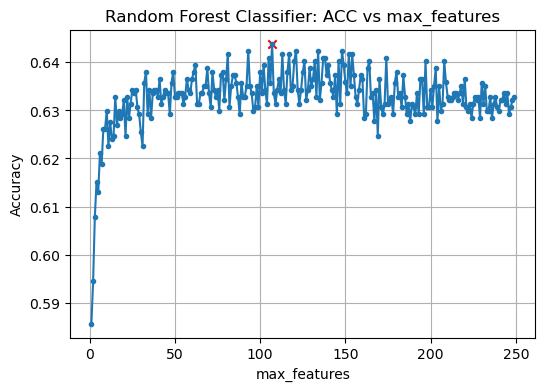

Max Accuracy 0.6438 found at x = 107
Execution Time: 24m 4.16s


In [27]:
# record beginning time
start = time.time()

param = 'max_features'  

parameter_list = range(1,250)  

accs = []

for n in tqdm(parameter_list):
    accs.append( run_random_forest_classifier(X_selected, y_train, 
                                n_estimators = 540,       
                                max_depth = 4,         
                                min_samples_split = 5,    
                                min_samples_leaf = 1,     
                                max_samples = .9,       
                                max_leaf_nodes = None,
                                max_features = n,             
                                ccp_alpha=0.0,
                               ) ) 


                            
# Find the max value
max_acc = max(accs)

# Find the index of the minimum value
max_index = accs.index(max_acc)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Classifier: ACC vs "+param)
plt.plot(parameter_list, accs, marker='.')
plt.scatter([parameter_list[max_index]],[max_acc],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("Accuracy")
plt.grid()
plt.show()

if isinstance(parameter_list[max_index], int):
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]}")
else:
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

100%|██████████| 11/11 [00:56<00:00,  5.16s/it]


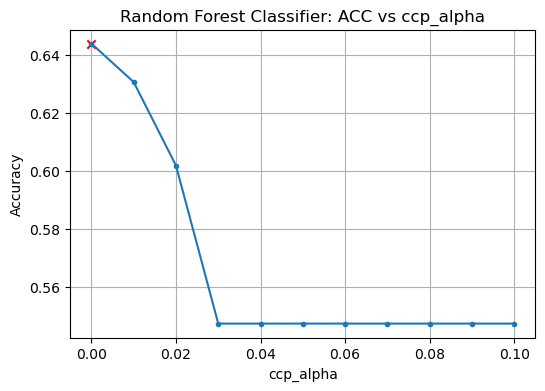

Max Accuracy 0.6438 found at x = 0
Execution Time: 56.84s


In [29]:
# record beginning time
start = time.time()

param = 'ccp_alpha'  

parameter_list = [0,.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]  

accs = []

for n in tqdm(parameter_list):
    accs.append( run_random_forest_classifier(X_selected, y_train, 
                                n_estimators = 540,       
                                max_depth = 4,         
                                min_samples_split = 5,    
                                min_samples_leaf = 1,     
                                max_samples = .9,       
                                max_leaf_nodes = None,
                                max_features = 107,             
                                ccp_alpha=n,
                               ) ) 


                            
# Find the max value
max_acc = max(accs)

# Find the index of the minimum value
max_index = accs.index(max_acc)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Classifier: ACC vs "+param)
plt.plot(parameter_list, accs, marker='.')
plt.scatter([parameter_list[max_index]],[max_acc],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("Accuracy")
plt.grid()
plt.show()

if isinstance(parameter_list[max_index], int):
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]}")
else:
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

In [30]:
run_random_forest_classifier(X_selected, y_train, 
                                n_estimators = 540,       
                                max_depth = 4,         
                                min_samples_split = 5,    
                                min_samples_leaf = 1,     
                                max_samples = .9,       
                                max_leaf_nodes = None,
                                max_features = 107             
                            )

0.6438463208161493